In [80]:
import pandas as pd

In [120]:
# LOAD DATA
# replication data from 2021 paper 
# country metadata and ground truth
country_metadata = pd.read_csv("../data/Analysis/data/tables/countries.csv")
actual_outcomes = pd.read_csv("../data/Analysis/data/tables/acd.csv") 
actual_outcomes = pd.merge(actual_outcomes, country_metadata[['gwcode', 'alpha3']], how='left', on="gwcode")
actual_outcomes = actual_outcomes.drop_duplicates()

import country_converter as coco
cc = coco.CountryConverter()
actual_outcomes['alpha3'] = cc.pandas_convert(series=actual_outcomes.gwcode, to='ISO3', src='gwcode')

# THESE FOUR COUNTRIES WE EXCLUDE FROM OUR ANALYSIS 
print('For these NOT FOUND countries, the gwcodes are not valid, we exclude them from analysis')
# Filter those countries from outcome data
actual_outcomes = actual_outcomes[actual_outcomes.alpha3 != 'not found']

816 not found in GWcode
751 not found in GWcode
678 not found in GWcode
345 not found in GWcode


For these NOT FOUND countries, the gwcodes are not valid, we exclude them from analysis


## Load VDEM v13 Core Data and Select Vars

In [121]:
# vdem core data v13
vdem_core = pd.read_csv("../data/vdem_core_v13/vdem_core_v13.csv")

# select country vars and the five high-level dem indicators
core_indicators = ['v2x_polyarchy', 'v2x_libdem', 'v2x_partipdem', 'v2x_delibdem', 'v2x_egaldem']
vdem_core = vdem_core[['country_name', 
           'country_text_id', 
           'country_id', 
           'year'] + core_indicators]

vdem_core

,country_name,country_text_id,country_id,year,v2x_polyarchy,v2x_libdem,v2x_partipdem,v2x_delibdem,v2x_egaldem
0,Mexico,MEX,3,1789,0.028,0.042,0.006,NaN,NaN
1,Mexico,MEX,3,1790,0.028,0.042,0.006,NaN,NaN
2,Mexico,MEX,3,1791,0.028,0.042,0.006,NaN,NaN
3,Mexico,MEX,3,1792,0.028,0.042,0.006,NaN,NaN
4,Mexico,MEX,3,1793,0.028,0.042,0.006,NaN,NaN
...,...,...,...,...,...,...,...,...,...
27550,Piedmont-Sardinia,SPD,373,1857,0.207,0.135,0.065,NaN,NaN
27551,Piedmont-Sardinia,SPD,373,1858,0.210,0.136,0.065,NaN,NaN
27552,Piedmont-Sardinia,SPD,373,1859,0.210,0.136,0.065,NaN,NaN
27553,Piedmont-Sardinia,SPD,373,1860,0.213,0.137,0.064,NaN,NaN


## Inflate actual_outcome dataframe with all four possibilities of conflict 'profiles' per year and country

In [122]:
for col in ['year', 'gwcode', 'minor_actual', 'major_actual']:
    actual_outcomes[col] = actual_outcomes[col].astype('category')

actual_outcomes = actual_outcomes.drop("gwcode", axis=1)
# Get conflict profiles per country and year from actual outcome data
# Step 0: Get indicator per country and year for which conflicts have happened
actual_outcomes = actual_outcomes.groupby(['year', 'alpha3', 'minor_actual', 'major_actual'], observed=False).count()[['intensity_level']].rename(columns={'intensity_level': 'true_false'}).reset_index()
# Step 1 & 2: Identify groups where all 'true_false' values are 0, hence there was no conflict in a given year
groups_with_all_false = actual_outcomes.groupby(['alpha3', 'year'], observed=False)[['true_false']].sum()
# Creating a list of index values for rows that meet the criteria for updating
index_to_update = groups_with_all_false[groups_with_all_false.true_false == 0].index
index_to_retain = groups_with_all_false[groups_with_all_false.true_false > 0].index
# Updating 'true_false' column in the original dataframe for the identified rows
# actual_outcomes.loc[index_to_update, 'true_false'] = 1


actual_outcomes

,year,alpha3,minor_actual,major_actual,true_false
0,1946,AFG,0.0,0.0,0
1,1946,AFG,0.0,1.0,0
2,1946,AFG,1.0,0.0,0
3,1946,AFG,1.0,1.0,0
4,1946,AGO,0.0,0.0,0
...,...,...,...,...,...
34159,2018,ZAF,1.0,1.0,0
34160,2018,ZWE,0.0,0.0,0
34161,2018,ZWE,0.0,1.0,0
34162,2018,ZWE,1.0,0.0,0


In [123]:
# Define a function to apply to each group
def check_and_update(group):
    # Check if there is any row with true_false == 1
    if (group['true_false'] == 1).any():
        return group  # If yes, return the group unchanged
    
    # If no row with true_false == 1, find the row with major_actual and minor_actual == 0 and update true_false
    condition = (group['major_actual'] == 0) & (group['minor_actual'] == 0)
    if condition.any():
        group.loc[condition, 'true_false'] = 1
    
    return group

# Group by year and alpha3, then apply the function
actual_outcomes = actual_outcomes.groupby(['year', 'alpha3'], observed=False).apply(check_and_update).reset_index(drop=True)

# Add countries that never experienced a conflict in the data and thus are not in the actual_outcomes file
dfs_to_add = []
for country in country_metadata.alpha3:
    if country not in actual_outcomes.alpha3.unique():
        for year in actual_outcomes.year.unique():
            dfs_to_add.append(pd.DataFrame({
                'year': [year]*4,
                'alpha3': [country]*4,
                'minor_actual': [0.0, 0.0, 1.0, 1.0],
                'major_actual': [0.0, 1.0, 0.0, 1.0],
                'true_false': [1,0,0,0]
            }))
actual_outcomes = pd.concat([actual_outcomes, pd.concat(dfs_to_add)]).reset_index(drop=True)

# Check if the operation was successful by displaying the first few rows
actual_outcomes

/var/folders/5z/_fy6xpc57_q0t8tg4bnrwfmm0000gn/T/ipykernel_27609/125810224.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  actual_outcomes = actual_outcomes.groupby(['year', 'alpha3'], observed=False).apply(check_and_update).reset_index(drop=True)


,year,alpha3,minor_actual,major_actual,true_false
0,1946,AFG,0.0,0.0,1
1,1946,AFG,0.0,1.0,0
2,1946,AFG,1.0,0.0,0
3,1946,AFG,1.0,1.0,0
4,1946,AGO,0.0,0.0,1
...,...,...,...,...,...
50803,2017,FJI,1.0,1.0,0
50804,2018,FJI,0.0,0.0,1
50805,2018,FJI,0.0,1.0,0
50806,2018,FJI,1.0,0.0,0


## Merge actual outcome data with vdem

In [142]:
data_merged = pd.merge(actual_outcomes, 
        vdem_core[['country_text_id', 'year'] + core_indicators], 
        right_on=['country_text_id', 'year'], 
        left_on=['alpha3', 'year'])


data_merged = data_merged[(data_merged['year'] >= 1970) & (data_merged['year'] <= 2000)].reset_index(drop=True)
data_merged

,year,alpha3,minor_actual,major_actual,true_false,country_text_id,v2x_polyarchy,v2x_libdem,v2x_partipdem,v2x_delibdem,v2x_egaldem
0,1970,AFG,0.0,0.0,1,AFG,0.160,0.109,0.037,0.105,0.092
1,1970,AFG,0.0,1.0,0,AFG,0.160,0.109,0.037,0.105,0.092
2,1970,AFG,1.0,0.0,0,AFG,0.160,0.109,0.037,0.105,0.092
3,1970,AFG,1.0,1.0,0,AFG,0.160,0.109,0.037,0.105,0.092
4,1970,AGO,0.0,0.0,0,AGO,0.009,0.033,0.011,0.018,0.016
...,...,...,...,...,...,...,...,...,...,...,...
19287,1999,FJI,1.0,1.0,0,FJI,0.558,0.418,0.296,0.424,0.364
19288,2000,FJI,0.0,0.0,1,FJI,0.351,0.213,0.207,0.199,0.259
19289,2000,FJI,0.0,1.0,0,FJI,0.351,0.213,0.207,0.199,0.259
19290,2000,FJI,1.0,0.0,0,FJI,0.351,0.213,0.207,0.199,0.259


In [143]:
# Impute missing values for TKM and KAZ in 1990 by filling average of dem index for all other years
data_merged.loc[(data_merged.v2x_polyarchy.isna()) & (data_merged.alpha3 == 'TKM'), 'v2x_polyarchy'] = data_merged[data_merged.alpha3 == 'TKM'].v2x_polyarchy.mean()
data_merged.loc[(data_merged.v2x_polyarchy.isna()) & (data_merged.alpha3 == 'KAZ'), 'v2x_polyarchy'] = data_merged[data_merged.alpha3 == 'KAZ'].v2x_polyarchy.mean()

In [144]:
# check if there are any NA values
data_merged.isna().any()

year               False
alpha3             False
minor_actual       False
major_actual       False
true_false         False
country_text_id    False
v2x_polyarchy      False
v2x_libdem          True
v2x_partipdem       True
v2x_delibdem        True
v2x_egaldem         True
dtype: bool

In [145]:
# Binning for each column in the DataFrame
n_bins = 3
for column in core_indicators:
    data_merged[f'{column}_b'] = pd.cut(data_merged[column], bins=n_bins, labels=False)
core_indicators_b = [i + '_b' for i in core_indicators]

for col in core_indicators_b:
    data_merged[col] = data_merged[col].astype('category')
data_merged

,year,alpha3,minor_actual,major_actual,true_false,country_text_id,v2x_polyarchy,v2x_libdem,v2x_partipdem,v2x_delibdem,v2x_egaldem,v2x_polyarchy_b,v2x_libdem_b,v2x_partipdem_b,v2x_delibdem_b,v2x_egaldem_b
0,1970,AFG,0.0,0.0,1,AFG,0.160,0.109,0.037,0.105,0.092,0,0.0,0.0,0.0,0.0
1,1970,AFG,0.0,1.0,0,AFG,0.160,0.109,0.037,0.105,0.092,0,0.0,0.0,0.0,0.0
2,1970,AFG,1.0,0.0,0,AFG,0.160,0.109,0.037,0.105,0.092,0,0.0,0.0,0.0,0.0
3,1970,AFG,1.0,1.0,0,AFG,0.160,0.109,0.037,0.105,0.092,0,0.0,0.0,0.0,0.0
4,1970,AGO,0.0,0.0,0,AGO,0.009,0.033,0.011,0.018,0.016,0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19287,1999,FJI,1.0,1.0,0,FJI,0.558,0.418,0.296,0.424,0.364,1,1.0,1.0,1.0,1.0
19288,2000,FJI,0.0,0.0,1,FJI,0.351,0.213,0.207,0.199,0.259,1,0.0,0.0,0.0,0.0
19289,2000,FJI,0.0,1.0,0,FJI,0.351,0.213,0.207,0.199,0.259,1,0.0,0.0,0.0,0.0
19290,2000,FJI,1.0,0.0,0,FJI,0.351,0.213,0.207,0.199,0.259,1,0.0,0.0,0.0,0.0


In [146]:
# Get UN region feature
data_merged['un_region'] = cc.pandas_convert(series=data_merged.alpha3, to='UNREGION', src='ISO3')
data_merged['un_region'] = data_merged['un_region'].astype('category')
data_merged.isna().any()

year               False
alpha3             False
minor_actual       False
major_actual       False
true_false         False
country_text_id    False
v2x_polyarchy      False
v2x_libdem          True
v2x_partipdem       True
v2x_delibdem        True
v2x_egaldem         True
v2x_polyarchy_b    False
v2x_libdem_b        True
v2x_partipdem_b     True
v2x_delibdem_b      True
v2x_egaldem_b       True
un_region          False
dtype: bool

In [228]:
def get_baseline_predictions(year_lower, year_upper, indicator):
    assert indicator in core_indicators_b

    # Filter year range
    data_years = data_merged[(data_merged['year'] >= year_lower) & (data_merged['year'] <= year_upper)].reset_index(drop=True)

    # Sum 'true_false' within each 'un_region', indicator, and 'minor_actual' group
    grouped_sum_minor = data_years.groupby(['un_region', indicator, 'minor_actual'], observed=True)['true_false'].sum().reset_index()
    # Calculate the total sum of 'true_false' for each 'un_region' and indicator combination, regardless of 'minor_actual'
    total_sum = grouped_sum_minor.groupby(['un_region', indicator], observed=True)['true_false'].transform('sum')
    # Calculate the fraction of 'true_false' for each 'minor_actual' category within each group
    grouped_sum_minor['prob_minor'] = grouped_sum_minor['true_false'] / total_sum
    grouped_sum_minor['prob_minor'] = grouped_sum_minor['prob_minor'].fillna(0.0)
    grouped_sum_minor = grouped_sum_minor.rename(columns={'true_false': 'minor_count_country_years'})

    # Sum 'true_false' within each 'un_region', indicator, and 'minor_actual' group
    grouped_sum_major = data_years.groupby(['un_region', indicator, 'major_actual'], observed=True)['true_false'].sum().reset_index()
    # Calculate the total sum of 'true_false' for each 'un_region' and indicator combination, regardless of 'minor_actual'
    total_sum = grouped_sum_major.groupby(['un_region', indicator], observed=True)['true_false'].transform('sum')
    # Calculate the fraction of 'true_false' for each 'minor_actual' category within each group
    grouped_sum_major['prob_major'] = grouped_sum_major['true_false'] / total_sum
    grouped_sum_major['prob_major'] = grouped_sum_major['prob_major'].fillna(0.0)
    grouped_sum_major = grouped_sum_major.rename(columns={'true_false': 'major_count_country_years'})

    return pd.merge(grouped_sum_minor, grouped_sum_major, how='left', left_on=['un_region', indicator, 'minor_actual'], right_on=['un_region', indicator, 'major_actual'])

predictions = get_baseline_predictions(1970, 2000, 'v2x_polyarchy_b')

predictions


,un_region,v2x_polyarchy_b,minor_actual,minor_count_country_years,prob_minor,major_actual,major_count_country_years,prob_major
0,Australia and New Zealand,2,0.0,62,1.000000,0.0,62,1.000000
1,Australia and New Zealand,2,1.0,0,0.000000,1.0,0,0.000000
2,Caribbean,0,0.0,62,0.984127,0.0,63,1.000000
3,Caribbean,0,1.0,1,0.015873,1.0,0,0.000000
4,Caribbean,1,0.0,55,0.982143,0.0,56,1.000000
...,...,...,...,...,...,...,...,...
93,Western Asia,1,1.0,16,0.173913,1.0,14,0.152174
94,Western Asia,2,0.0,23,0.433962,0.0,51,0.962264
95,Western Asia,2,1.0,30,0.566038,1.0,2,0.037736
96,Western Europe,2,0.0,248,1.000000,0.0,248,1.000000


In [229]:
# bring prediction data into same format as their prediction files, so we only retain positive event probabilities
predictions = predictions[predictions.minor_actual == 1].reset_index(drop=True)

# Assign countries to prediction category with their dem index they had in the year 2000
predictions = pd.merge(predictions, data_merged[data_merged.year == 2000][['un_region', 'v2x_polyarchy_b', 'alpha3']].drop_duplicates().reset_index(drop=True), how='left', on=['un_region', 'v2x_polyarchy_b']).dropna().reset_index(drop=True)

# Get gwcode back
predictions = pd.merge(predictions, country_metadata[['alpha3', 'gwcode']].drop_duplicates().reset_index(drop=True), how='left')

# Extend dataframe such that we regained year column
predictions = pd.concat([predictions.assign(Year=year) for year in range(2001, 2019)], ignore_index=True)

# drop unnecessary columns to get same format as hegre
predictions = predictions[['gwcode', 'Year', 'prob_minor', 'prob_major', 'un_region', 'v2x_polyarchy_b']]

predictions

,gwcode,Year,prob_minor,prob_major,un_region,v2x_polyarchy_b
0,900,2001,0.000000,0.0,Australia and New Zealand,2
1,920,2001,0.000000,0.0,Australia and New Zealand,2
2,40,2001,0.015873,0.0,Caribbean,0
3,41,2001,0.017857,0.0,Caribbean,1
4,42,2001,0.014925,0.0,Caribbean,2
...,...,...,...,...,...,...
3019,211,2018,0.000000,0.0,Western Europe,2
3020,212,2018,0.000000,0.0,Western Europe,2
3021,225,2018,0.000000,0.0,Western Europe,2
3022,260,2018,0.000000,0.0,Western Europe,2


<Axes: ylabel='Frequency'>

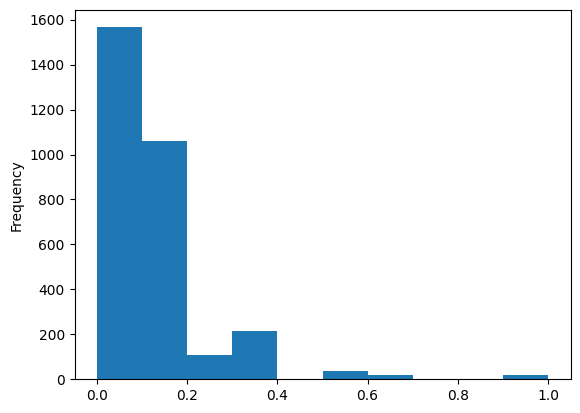

In [230]:
predictions.prob_minor.plot.hist()

<Axes: ylabel='Frequency'>

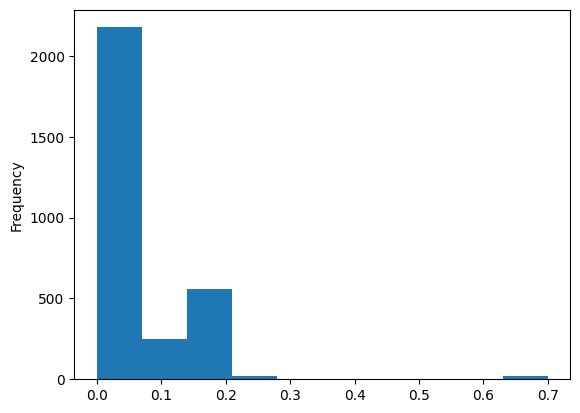

In [231]:
predictions.prob_major.plot.hist()

In [232]:
predictions.to_csv('predictions_baseline_1970_2000.csv', index=False)